# Granger causality demo

#### 14th May 2024

cMLP demo from the work of [Tank et. al](https://arxiv.org/abs/1802.05842)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_var
from models.cmlp import cMLP, cMLPSparse, train_model_ista, train_unregularized, train_model_adam

max_iter_max = 30000
check_every = np.floor(np.sqrt(max_iter_max))

In [2]:
# For GPU acceleration
device = torch.device('cpu')# torch.device('cuda')

## Financial data

0
0
0
0
0
0
0
0
0
0
0
0
(12, 1251)


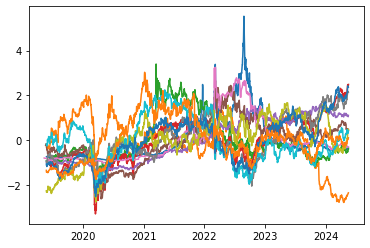

In [20]:
import yfinance as yf
import numpy as np

# Define the symbols
# symbols = ['TTF=F', 'NG=F', 'BAYRY', 'VWAGY', '^GDAXI', 'LNG', 'SHEL', 'EURUSD=X']
symbols = [
    'TTF=F', 
    #'NG=F', 
    'BAYRY', 'VWAGY', 
    '^GDAXI', 'LNG', 
    #'SHEL', 'EURUSD=X',
    #'RUB=X', 'RELIANCE.BO', 
    'BZ=F', 'MTF=F', 
    #'BP', 'TTE', 
    'EONGY', 'RWEOY', 
    'BASFY', 'SIEGY', 'VWDRY'
]
# Fetch data for each symbol
data = {}
for symbol in symbols:
    ticker = yf.Ticker(symbol)
    data[symbol] = ticker.history(period="5y")['Close']

# Ensure all time series have the same length
min_length = min(len(data[symbol]) for symbol in symbols)

# Trim each series to the minimum length
for symbol in symbols:
    data[symbol] = data[symbol][-min_length:]

# Normalize each time series by dividing by its average value
normalized_data = {}
for symbol in symbols:
    avg_value = data[symbol].mean()
    sd = data[symbol].std()
    normalized_data[symbol] = (data[symbol] - avg_value)/sd
    plt.plot(normalized_data[symbol])
    print(normalized_data[symbol].isna().sum())

# Stack the normalized time series data into a single numpy array
time_series_data = np.array([normalized_data[symbol].values for symbol in symbols])

# Reshape to (1, number_timesteps, number_time_series)
time_series_data2 = time_series_data.T[np.newaxis, :, :]

print(time_series_data.shape)  # Should print (1, min_length, 10)


In [18]:
normalized_data['BAYRY'].isna().sum()

0

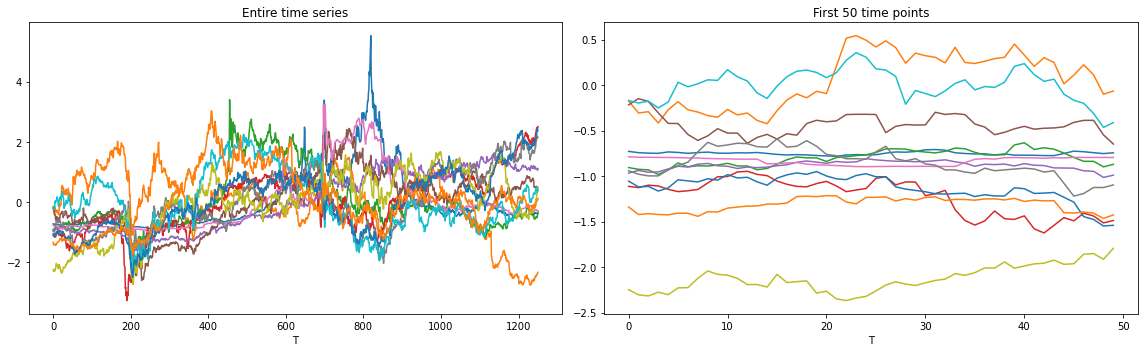

In [5]:
X = torch.tensor(time_series_data2, dtype=torch.float32, device=device)
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
for i in range(time_series_data.shape[0]):
    axarr[0].plot(time_series_data[i])
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
for i in range(time_series_data.shape[0]):
    axarr[1].plot(time_series_data[i,:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

In [6]:
cmlp = cMLP(X.shape[-1], lag=5, hidden=[100])#.cuda(device=device)
# Train with ISTA
train_loss_list = train_model_ista(
    cmlp, X, lam=0.002, lam_ridge=1e-2, lr=5e-2, penalty='H', 
    max_iter=max_iter_max,
    check_every=check_every)

----------Iter = 173----------
Loss = 0.165110
Variable usage = 100.00%
----------Iter = 346----------
Loss = 0.154349
Variable usage = 100.00%
----------Iter = 519----------
Loss = 0.145475
Variable usage = 100.00%
----------Iter = 692----------
Loss = 0.137334
Variable usage = 100.00%
----------Iter = 865----------
Loss = 0.129652
Variable usage = 100.00%
----------Iter = 1038----------
Loss = 0.122311
Variable usage = 100.00%
----------Iter = 1211----------
Loss = 0.115260
Variable usage = 100.00%
----------Iter = 1384----------
Loss = 0.108457
Variable usage = 100.00%
----------Iter = 1557----------
Loss = 0.101910
Variable usage = 100.00%
----------Iter = 1730----------
Loss = 0.095609
Variable usage = 100.00%
----------Iter = 1903----------
Loss = 0.089567
Variable usage = 100.00%
----------Iter = 2076----------
Loss = 0.083801
Variable usage = 100.00%
----------Iter = 2249----------
Loss = 0.078323
Variable usage = 100.00%
----------Iter = 2422----------
Loss = 0.073147
Variable

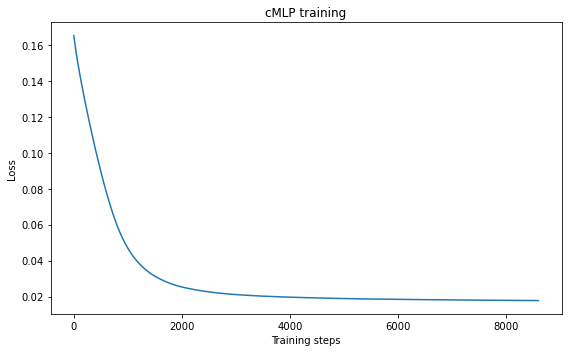

In [7]:
# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cMLP training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

Estimated variable usage = 61.81%


[]

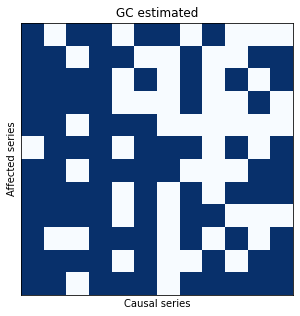

In [8]:
GC_est = cmlp.GC().cpu().data.numpy()

print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))


# Make figures
fig, axarr = plt.subplots(1, 1, figsize=(16, 5))
axarr.imshow(GC_est, cmap='Blues')
axarr.set_title('GC estimated')
axarr.set_ylabel('Affected series')
axarr.set_xlabel('Causal series')
axarr.set_xticks([])
axarr.set_yticks([])


In [9]:
GC_est

array([[1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
       [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]], dtype=int32)

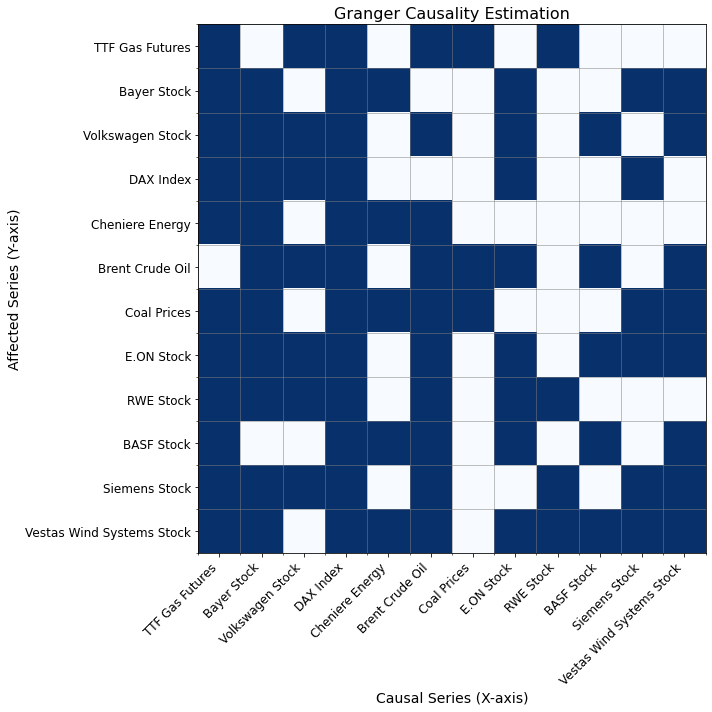

In [10]:
# Human-readable names for the series
series_names = [
    'TTF Gas Futures', 
    #'Natural Gas (NA)', 
    'Bayer Stock', 'Volkswagen Stock',
    'DAX Index', 'Cheniere Energy', 
    #'Shell Stock', 'EUR/USD Exchange Rate',
    #'RUB/EUR Exchange Rate', 'Reliance Stock', 
    'Brent Crude Oil', 'Coal Prices', 
    #'BP Stock', 'TotalEnergies Stock', 
    'E.ON Stock', 'RWE Stock', 
    'BASF Stock', 'Siemens Stock', 'Vestas Wind Systems Stock'
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the matrix
cax = ax.imshow(GC_est, cmap='Blues', aspect='auto')

# Set title and axis labels
ax.set_title('Granger Causality Estimation', fontsize=16)
ax.set_xlabel('Causal Series (X-axis)', fontsize=14)
ax.set_ylabel('Affected Series (Y-axis)', fontsize=14)

# Set ticks and labels
ax.set_xticks(np.arange(len(series_names)))
ax.set_yticks(np.arange(len(series_names)))

ax.set_xticklabels(series_names, fontsize=12, rotation=45, ha='right')
ax.set_yticklabels(series_names, fontsize=12)


# Add gridlines based on the minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5, len(series_names), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(series_names), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('granger_causality_estimation.png', dpi=300, bbox_inches='tight',  facecolor='white')
plt.show()

In [11]:
import networkx as nx

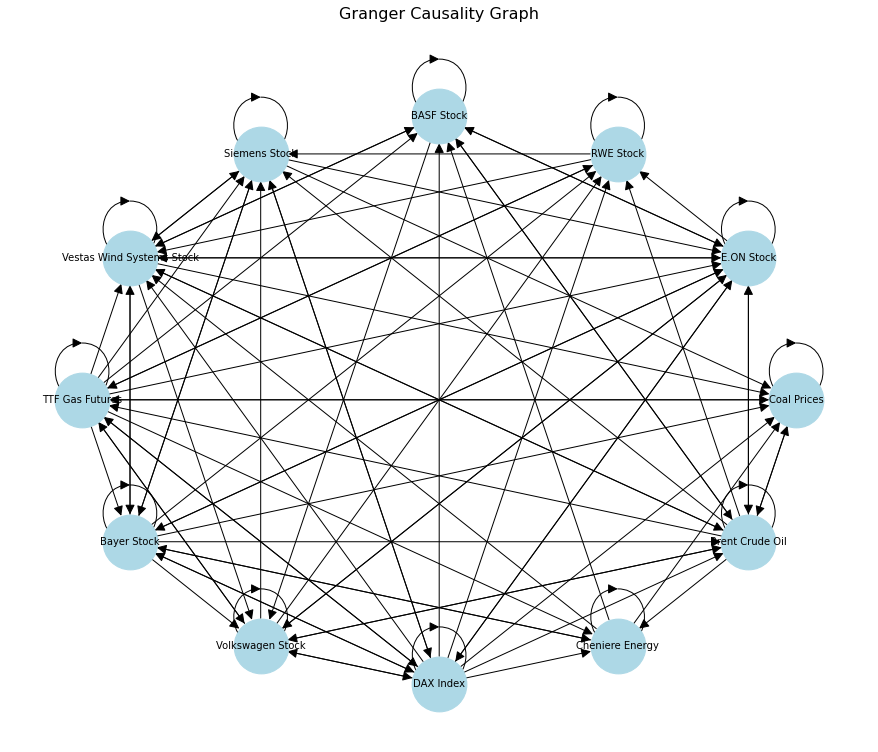

In [12]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
for idx, name in enumerate(series_names):
    G.add_node(idx, label=name)

# Add edges based on GC_est matrix
for x in range(GC_est.shape[0]):
    for y in range(GC_est.shape[1]):
        if GC_est[x, y] == 1:
            G.add_edge(y, x)

# Define position for nodes
pos = nx.shell_layout(G)  # You can change the layout if needed

# Draw the graph
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', arrowsize=20, font_size=10,
        labels=nx.get_node_attributes(G, 'label'))

plt.title('Granger Causality Graph', fontsize=16)
plt.savefig('granger_causality_est_graph.png', dpi=300, bbox_inches='tight',  facecolor='white')
plt.show()